In [2]:
#import necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Loading Dataset
df = pd.read_csv(r"D:/Madura Cotts Dataset/pizza_customers.csv")
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
df.shape

(200, 5)

In [5]:
# Checking is there any null values 
df.isnull().any()

CustomerID                False
Gender                    False
Age                       False
Annual Income (k$)        False
Spending Score (1-100)    False
dtype: bool

In [6]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


# Pre Processing

In [7]:
# dropping customer id as it does not contribute any useful information for clustering
df.drop(["CustomerID"], inplace = True, axis = 1)

#Renaming these columns for ease of use
df.rename(columns = {"Annual Income (k$)" : "Annual Income", "Spending Score (1-100)" : "Spending Score"}, inplace = True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Gender          200 non-null    object
 1   Age             200 non-null    int64 
 2   Annual Income   200 non-null    int64 
 3   Spending Score  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.4+ KB


In [9]:
# Get categorical and continuous variables
continuous_data_types = ["int64", "float64"]

continous_columns = df.select_dtypes(include= continuous_data_types).columns
categorical_columns = df.select_dtypes(include = "object").columns
categorical_columns

Index(['Gender'], dtype='object')

In [10]:
# Encoding the categorical columns "Gender" using one hot encoding
df_gender = pd.get_dummies(df[categorical_columns], drop_first = True)
df_gender

,Gender_Male
0,1
1,1
2,0
3,0
4,0
...,...
195,0
196,0
197,1
198,1


In [11]:
#The encoded columns is concatenated to original dataframe and the gender column was dropped
df = pd.concat([df, df_gender], axis = 1)
df.drop(categorical_columns, axis = 1, inplace = True)

In [12]:
df.head()

,Age,Annual Income,Spending Score,Gender_Male
0,19,15,39,1
1,21,15,81,1
2,20,16,6,0
3,23,16,77,0
4,31,17,40,0


In [13]:
# Splitting the dataset into train and test
df_train, df_test = train_test_split(df, test_size = 0.1, random_state = 100)
df_train.reset_index(drop = True, inplace=True)

In [14]:
# Removing outliers from the train set
Q1 = df_train.quantile(0.25)
Q3 = df_train.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
clean_data = df_train[~((df_train < lower_bound) | (df_train > upper_bound)).any(axis=1)]

In [15]:
df_train = clean_data
df_train.shape

(178, 4)

In [16]:
#Scaling the numerical features using Standard Scaler
scaler = StandardScaler()

df_train[continous_columns] = scaler.fit_transform(df_train[continous_columns])
# df_train = pd.DataFrame(df_train, columns = df.columns)
df_test[continous_columns] = scaler.transform(df_test[continous_columns])

In [17]:
df_train

,Age,Annual Income,Spending Score,Gender_Male
0,-0.287314,-1.572712,1.874977,0
1,1.476197,-0.331370,0.216660,0
2,-1.204339,-1.532669,1.103667,1
3,-1.063258,-0.811889,1.605019,1
4,-0.851637,0.069063,-0.014733,0
...,...,...,...,...
175,-1.204339,-0.051066,0.178095,0
176,-0.922177,0.149150,0.178095,1
177,2.040521,-0.411456,-0.091864,0
178,1.052955,-1.212322,-1.403092,0


# K - Means Clustering

In [18]:
# Implementation of Kmeans
np.random.seed(100)

class KMeans:
    def __init__(self, n_cluster = 3, iterations = 200, num_runs = 50): # Initialize all the default values
        self.n_cluster = n_cluster
        self.iterations = iterations
        self.num_runs = num_runs
        self.best_centroids = None
        self.best_labels = None
        self.best_wcss = float('inf')
        self.centroids = None
        
    def fit(self, data):
        # Picking up random points and as initial centroids
         for _ in range(self.num_runs):
            index = np.random.choice(len(data), self.n_cluster, replace=False)
            self.centroids = data[index]
        
        #Find clusters and update them iteratively and if the old and new centroids are same then stop the iteration
            for i in range(self.iterations):
                clusterLabels = self.setClusters(data)
                new_centroids = self.update_centroids(data, clusterLabels)

                if np.all(new_centroids == self.centroids):
                    break

                self.centroids = new_centroids
                
                # As the intial data points are randomly picked, find "within cluster sum of squares" for a differently picked 
                # random point and store the best one for a particular cluster
                wcss = self.calculate_wcss(data)
                if wcss < self.best_wcss:
                    self.best_wcss = wcss
                    self.best_centroids = self.centroids
                    self.best_labels = clusterLabels
            
    def setClusters(self, data):
        labels = np.empty(len(data))
        size = len(data)
    
        # Calculate Euclidean Distance for a data point and all the centroid
        for i in range(size):
            distanceFromClusters = np.linalg.norm(data[i] - self.centroids, axis = 1)
            
            # Assigning the data point to the cluster with minimum distance
            labels[i] = np.argmin(distanceFromClusters)
        
        return labels
        
    def update_centroids(self, data, labels):
        
        updated_centroids = np.empty((self.n_cluster, len(data[1])))
        
        # Find all the points belonging to a cluster and find the mean of the data points to update the centroids
        for cluster_num in range(self.n_cluster):
            points = data[labels == cluster_num]
            
            updated_centroids[cluster_num] = np.mean(points, axis = 0)
        
        return updated_centroids
    
    # Calculate "Within Cluster sum of squares" to find the optimal number of clusters
    def calculate_wcss(self, data):
        
        wcss = 0
        labels = self.setClusters(data)
        
        for i in range(self.n_cluster):
            points = data[labels == i]
            centroid = self.centroids[i]
            
            wcss = np.sum((points - centroid) ** 2)
            
        return wcss

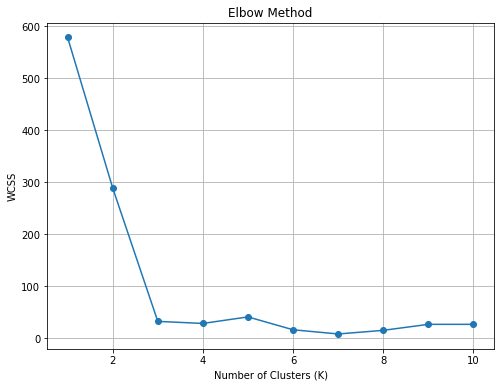

In [19]:
# Performing K-Means for all the clusters from 1 to 11 and plotting the elbow graph.
# Using the elbow graph to find the optimal number of clusters
wcss_val = []
data = df_train.to_numpy()
cluster_values = [val for val in range(1, 11)]

for val in cluster_values:
    kmeans = KMeans(val, 500)   
    kmeans.fit(data)  
    labels = kmeans.setClusters(data)
    wcss = kmeans.calculate_wcss(data)
    wcss_val.append(wcss)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss_val, marker='o', linestyle='-')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.grid()
plt.show()


In [20]:
# Elbow point is 3
# Fit the K-means model for 3 clusters
kmeans = KMeans(3, 100)
kmeans.fit(data)

In [21]:
# Creater another column in the dataframe and allocate the clusters
labels = kmeans.setClusters(data)
labels = labels.astype(int)
df_train["Cluster"] = np.array(labels)

In [22]:
kmeans.best_centroids

array([[-0.92602504, -0.7652934 ,  0.32254009,  0.4       ],
       [ 0.73512636,  0.05376601, -0.66428022,  0.46067416],
       [-0.42631967,  1.09723417,  1.21709512,  0.47058824]])

In [23]:
len0 = len(df_train[df_train["Cluster"] == 0])
len1 = len(df_train[df_train["Cluster"] == 1])
len2 = len(df_train[df_train["Cluster"] == 2])

len0, len1, len2

(39, 85, 54)

# Clustering Results
 - Number of Clusters : 3
 <br> </br>
 - Centroids : 
     * Cluster 1 : [-0.92602504, -0.7652934 ,  0.32254009,  0.4       ]
     * Cluster 2 : [ 0.73512636,  0.05376601, -0.66428022,  0.46067416]
     * Cluster 3 : [-0.42631967,  1.09723417,  1.21709512,  0.47058824]
 <br> </br>
     
 - Number of data in Clusters:
     * Number of data in cluster 0 : 39
     * Number of data in cluster 1 : 85
     * Number of data in cluster 2 : 54

In [24]:
df_train[continous_columns] = scaler.inverse_transform(df_train[continous_columns]) 

In [25]:
df_train["Gender_Male"] = df_train["Gender_Male"].map({0 : 'Female', 1 : 'Male'})

In [26]:
df_train.head()

,Age,Annual Income,Spending Score,Gender_Male,Cluster
0,35.0,19.0,99.0,Female,2
1,60.0,50.0,56.0,Female,1
2,22.0,20.0,79.0,Male,2
3,24.0,38.0,92.0,Male,2
4,27.0,60.0,50.0,Female,2


# Exercise 2

In [27]:
df_0 = df_train[df_train["Cluster"] == 0]
df_1 = df_train[df_train["Cluster"] == 1]
df_2 = df_train[df_train["Cluster"] == 2]

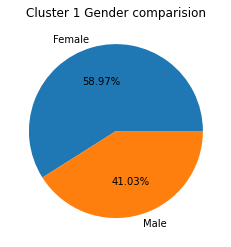

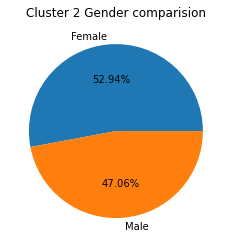

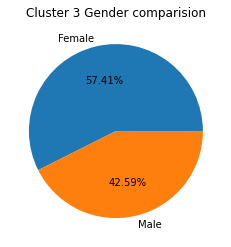

In [28]:
#Comparing male and  female ratio in the clusters
zero = df_0['Gender_Male'].value_counts().values
plt.pie(zero, labels = ['Female', 'Male'], autopct='%1.2f%%')
plt.title("Cluster 1 Gender comparision")
plt.show()

one = df_1['Gender_Male'].value_counts().values
plt.pie(one, labels = ['Female', 'Male'], autopct='%1.2f%%')
plt.title("Cluster 2 Gender comparision")
plt.show()

two = df_2['Gender_Male'].value_counts().values
plt.pie(two, labels = ['Female', 'Male'], autopct='%1.2f%%')
plt.title("Cluster 3 Gender comparision")
plt.show()

In [29]:
#Find mean for each feature with respect to their cluster
m = df_train.groupby(["Cluster"]).mean().reset_index()
m.set_index("Cluster")

,Age,Annual Income,Spending Score
Cluster,,,
0,33.410256,86.076923,76.358974
1,50.364706,56.882353,32.776471
2,25.388889,40.388889,59.333333


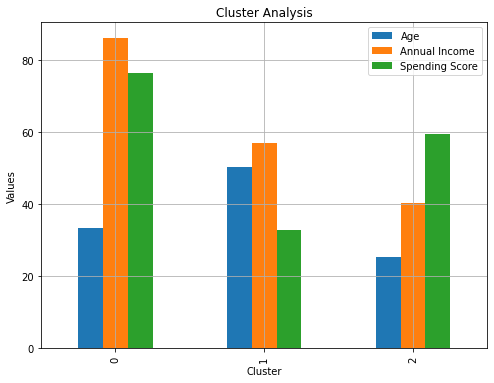

In [30]:
# Multiple bar chart
m.plot(x='Cluster', kind='bar', figsize=(8, 6))

plt.xlabel('Cluster')
plt.ylabel('Values')
plt.title('Cluster Analysis')
plt.grid()
plt.show()

# Cluster Nomenclature

 - From the above pie chats it can be seen that the gender parity is not significantly different
 - The clusters can definitely be segmented into 
     * High spenders (Cluster 0)
     * Low spenders (Cluster 1)
     * Medium spenders (Cluster 2)
     <br> </br>
 - Low Spenders are old people and they have a moderate income
 - Medium Spenders are youngsters and they have a low income
 - High Spenders are Middle aged people and they have high income
     <br> </br>
 
 - The above statements are validated by finding the mean for the each of the clusters with respect to each features and the values are visualized thus, providing the insights
 
 - So, spending score is the criteria that is used to name the clusters which is found through the large deviation between means of this cluster for this feature

# Marketing Offer

 #### Low Spenders:
  - Senior Discounts
  - Provide customization offers which would contain small comfortable portions of food

 #### Medium Spenders:
  - Student Discounts
  - Combo Deals
  - Special Discounts during evening and night
  - Coupons
 #### High Spenders:
  - Loyalty rewards : Give points for their visits
  - Family sized pizza bundle offers
  - Anniversary Discounts
 
 # General Offer
 - Pizza of the day given at a discounted price
 - Seasonal Special and discounts
 - Birthday discounts

# Clustering the test data

In [31]:
df_valid = df_test
df_v = df_valid.to_numpy()

In [32]:
c = kmeans.setClusters(df_v)
c

array([1., 1., 2., 1., 2., 0., 1., 1., 2., 2., 1., 2., 1., 1., 0., 0., 1.,
       0., 0., 2.])

In [33]:
df_valid["Cluster"] = c
df_valid

,Age,Annual Income,Spending Score,Gender_Male,Cluster
126,0.277010,0.509540,-0.593216,1,1.0
104,0.700252,0.149150,0.216660,1,1.0
99,-1.345420,0.109107,-0.053298,1,2.0
92,0.629712,0.069063,-0.053298,1,1.0
111,-1.415960,0.189193,0.139529,0,2.0
167,-0.428394,1.110189,1.720715,0,0.0
116,1.687818,0.269280,-0.284692,0,1.0
96,0.559172,0.069063,-0.130429,0,1.0
52,-0.569475,-0.611673,0.139529,0,2.0
69,-0.498935,-0.411456,-0.130429,0,2.0


In [34]:
df_valid[continous_columns] = scaler.inverse_transform(df_valid[continous_columns])
df_valid.head()

,Age,Annual Income,Spending Score,Gender_Male,Cluster
126,43.0,71.0,35.0,1,1.0
104,49.0,62.0,56.0,1,1.0
99,20.0,61.0,49.0,1,2.0
92,48.0,60.0,49.0,1,1.0
111,19.0,63.0,54.0,0,2.0
